In [1]:
import torch
import torch.nn.functional as F

## decoder block

![decoder](https://miro.medium.com/v2/resize:fit:4800/format:webp/0*VyyeYkd7BQOcgr3z)

In [12]:
x = torch.randn(2,3,3)
print(x)
tril = torch.tril(torch.ones(3,3))
x.masked_fill(tril==0, float('-inf'))

tensor([[[-2.1050,  1.3228,  1.1724],
         [-0.5476, -1.6462, -0.0696],
         [ 0.8495, -0.0414,  0.6126]],

        [[-0.7147,  0.5593,  0.9605],
         [-0.5712,  0.4056,  0.0851],
         [-1.1631,  0.5374,  1.4775]]])


tensor([[[-2.1050,    -inf,    -inf],
         [-0.5476, -1.6462,    -inf],
         [ 0.8495, -0.0414,  0.6126]],

        [[-0.7147,    -inf,    -inf],
         [-0.5712,  0.4056,    -inf],
         [-1.1631,  0.5374,  1.4775]]])

In [94]:
from torch import nn
import math
import torch.nn.functional as F

n_head = 8
n_embed = 512
vocab_size = 10254
n_seq = 16

class Attention(nn.Module):
    def __init__(self, n_seq:int, n_embed:int, hidden_size:int):
        super().__init__()
        self.hidden_size = hidden_size
        self.wq = nn.Linear(n_embed, hidden_size, bias=False)
        self.wk = nn.Linear(n_embed, hidden_size, bias=False)
        self.wv = nn.Linear(n_embed, hidden_size, bias=False)
        self.mask = torch.tril(torch.ones(n_seq, n_seq))
    
    def forward(self, x):
        q,k,v = self.wq(x), self.wk(x),self.wv(x)
        x = torch.matmul(q, k.transpose(-2,-1))
        x = (x.masked_fill(self.mask==0, float('-inf')))/math.sqrt(self.hidden_size)
        x = F.softmax(x, dim=-1)
        return torch.matmul(x, v)

In [95]:
x = torch.randn(2,16,4)
attn = Attention(16,4,4)
attn(x).shape

torch.Size([2, 16, 4])

![mha](https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png)

In [96]:
torch.cat([torch.randn(2,3,4),torch.randn(2,3,4)], dim=-1).shape

torch.Size([2, 3, 8])

In [97]:
class MultiHeadAttn(nn.Module):
    def __init__(self, n_seq:int, n_embed:int, n_head:int):
        super().__init__()
        self.heads = nn.ModuleList(
            [Attention(n_seq, n_embed, n_embed//n_head) for _ in range(n_head)]
        )
        self.linear1 = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = torch.concat([attn(x) for attn in self.heads], dim=-1)
        return self.dropout(self.linear1(x))
        

In [98]:
x = torch.randn(2, 16, 4)
mha = MultiHeadAttn(16, 4, 2)
mha(x).shape

torch.Size([2, 16, 4])

![mha](https://raw.githubusercontent.com/anicolson/DeepXi/refs/heads/master/docs/fig_mhanet.jpg)

In [99]:
class FeedForward(nn.Module):
    def __init__(self, n_embed:int):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed),
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(0.1),
        )

    def forward(self, x):
        return self.ffn(x)

In [100]:
class DecoderBlock(nn.Module):
    def __init__(self, n_seq:int, n_embed:int, n_head:int):
        super().__init__()
        self.mha = MultiHeadAttn(n_seq, n_embed, n_head)
        self.ffn = FeedForward(n_embed)
        self.norm1 = nn.LayerNorm(n_embed)
        self.norm2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.mha(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x
        

In [101]:
x = torch.randn(2, 16, 4)
decoder = DecoderBlock(16, 4, 2)
decoder(x).shape

torch.Size([2, 16, 4])

In [102]:
pos = torch.arange(0,16).unsqueeze(1) # 16*1
div_term = torch.exp(math.log(10000.0) * torch.arange(0, 4, 2).float()) / 4 # 1*2
torch.sin((pos*div_term)).shape

torch.Size([16, 2])

In [103]:

class NanoGPT(nn.Module):
    def __init__(self, vocab_size:int, n_block:int, n_seq:int, n_embed:int, n_head:int):
        super().__init__()
        self.blocks = nn.Sequential(*([DecoderBlock(n_seq, n_embed, n_head) for _ in range(n_block)]+[nn.LayerNorm(n_embed)]))
        self.vocab_linear = nn.Linear(n_embed, vocab_size)
        self.te_lookup_table = nn.Embedding(vocab_size, n_embed)
        self.n_seq = n_seq
        self.n_embed = n_embed

    def forward(self, x, y_batch=None):
        # B, T = x.shape
        pe_lookup_table = torch.zeros(self.n_seq, self.n_embed)
        position = torch.arange(0, self.n_seq, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(-math.log(10000.0) * torch.arange(0, self.n_embed, 2).float() / self.n_embed)
        pe_lookup_table[:, 0::2] = torch.sin(position * div_term)
        pe_lookup_table[:, 1::2] = torch.cos(position * div_term)

        x = self.te_lookup_table(x) + pe_lookup_table
        x = self.blocks(x)
        logits = self.vocab_linear(x)

        if y_batch:
            B, T, D = logits.shape
            loss = F.cross_entropy(logits.view(B*T, D), y_batch.view(B*T))
        else:
            loss = None
        return logits, loss
        
        

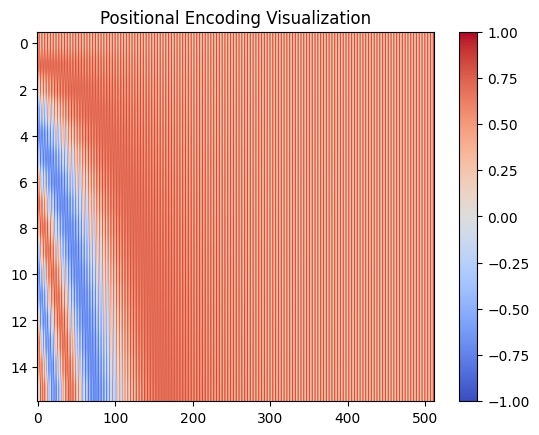

In [104]:
import matplotlib.pyplot as plt

position = torch.arange(0, 16).float().unsqueeze(1) # 16*1
div_term = torch.exp(-math.log(10000.0) * torch.arange(0, 512, 2).float() / 512) # 1*256
pe_lookup_table = torch.zeros(16, 512)
pe_lookup_table[:, 0::2] = torch.sin(position * div_term)
pe_lookup_table[:, 1::2] = torch.cos(position * div_term)
plt.imshow(pe_lookup_table.numpy(), cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title("Positional Encoding Visualization")
plt.show()

In [105]:
torch.randint(size=(2,16), low=0, high=1024)

tensor([[ 323,  665,  832,  349,  457,  676,  379,  102, 1012,  305,  251,  758,
          640,  362,  997,  461],
        [ 736,  125,  280, 1014,  121,  773,  594,  465,  162,  125,  122,  404,
          154,  903,  105,  357]])

In [106]:
x = torch.randint(low=0, high=1024, size=(2,16))
gpt = NanoGPT(1024, 2, 16, 4, 2)
logits,_ = gpt(x)
torch.argmax(logits, dim=-1).unsqueeze(-1)

tensor([[[  65],
         [ 238],
         [ 191],
         [ 466],
         [ 466],
         [1009],
         [1009],
         [  65],
         [ 466],
         [1009],
         [  27],
         [ 466],
         [ 466],
         [1009],
         [ 954],
         [ 138]],

        [[ 466],
         [1009],
         [ 238],
         [ 817],
         [ 226],
         [1009],
         [ 466],
         [1009],
         [ 466],
         [ 954],
         [ 138],
         [  27],
         [ 537],
         [ 388],
         [ 780],
         [ 191]]])